[View in Colaboratory](https://colab.research.google.com/github/jpskycak/research_notebooks/blob/master/programmable_self_assembly.ipynb)

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import random
  
def linf_distance((a,b),(x,y)):
  return max(abs(a-x),abs(b-y))
def l1_distance((a,b),(x,y)):
  return abs(a-x)+abs(b-y)
def displacement(initial,terminal):
  return (terminal[0]-initial[0], terminal[1]-initial[1])
def get_coordinates(array):
  return [(i,j) for i,row in enumerate(array) for j,val in enumerate(row) if val==1]
def arrow(direction):
  # arrows: http://xahlee.info/comp/unicode_arrows.html
  arrowdict = {'(-1, 0)':'🡑',
              '(-1, 1)':'🡕',
              '(0, 1)':'🡒',
              '(1, 1)':'🡖',
              '(1, 0)':'🡓',
              '(1, -1)':'🡗',
              '(0, -1)':'🡐',
              '(-1, -1)':'🡔'}
  return arrowdict[str(direction)]
def is_connected(pointlist,center):
  displist = [displacement(center,p) for p in pointlist]
  full_clockwise = [(-1,0),(-1,1),(0,1),(1,1),(1,0),(1,-1),(0,-1),(-1,-1)]
  clockwise = [p for p in full_clockwise if p in displist]
  n = len(clockwise)
  distance_to_next = [linf_distance(clockwise[i],clockwise[(i+1)%n]) for i in range(n)]
  num_breaks = sum([bool(d>1) for d in distance_to_next])
  if num_breaks>1:
    return False
  else:
    return True
  
class Agents:
  
  ##########################
  ### PLOTTING / LOGGING ###
  ##########################
  
  def make_grid(self,highlight_agents_by_index=[],gradient=False):
    grid = np.ones((self.grid_shape[0],self.grid_shape[1],3))
    for p in self.template_coordinates:
      grid[p][0] = 1
      grid[p][1] = 1
      grid[p][2] = 125
      
    if gradient:
      max_gradient = max(self.gradient)
      for i,p in enumerate(self.agent_coordinates):
        val = 100+ 100*float(self.gradient[i])/max_gradient
        grid[p][0] = val
        grid[p][1] = val
        grid[p][2] = val
        if self.activity[i] == False:
          grid[p][2] = 1
        if i in highlight_agents_by_index:
          grid[p][1] = 1
    else:
      for i,p in enumerate(self.agent_coordinates):
        grid[p][0] = 200
        grid[p][1] = 200
        grid[p][2] = 200
        if self.activity[i] == False:
          grid[p][2] = 1
        if i in highlight_agents_by_index:
          grid[p][1] = 1
        
    return grid
  
  def update_logarray(self,highlight_agents_by_index=[]):
    grid = self.make_grid(highlight_agents_by_index=highlight_agents_by_index)
    self.logarray.append(grid)
    
  def plot(self,t=0,logarrayskip=1,showgradient=False):
    print self.logstr[t]
    if t != -1:
      grids = [self.logarray[logarrayskip+2*t],self.logarray[logarrayskip+2*t+1]]
      xyglist = [zip(a.coordinates_log[t],a.gradient_log[2*t+1]),zip(a.coordinates_log[t+1],a.gradient_log[2*t+2])]
    elif t == -1:
      grids = [self.logarray[logarrayskip+2*t]]
      xyglist = [zip(a.coordinates_log[t],a.gradient_log[2*t+1])]
    for grid in grids:
      plt.imshow(grid)
      plt.grid(False)
      plt.show()
    if showgradient:
      for xyg in xyglist:
        gradarray = np.zeros(self.grid_shape)
        for ((x,y),g) in xyg:
          gradarray[x,y] = float(5+g)/10
        plt.imshow(gradarray)
        plt.grid(False)
        plt.show()
  
  #########################
  ### UPDATES UTILITIES ###
  #########################
  
  def prospective_location(self,i):
    (x0,y0) = self.agent_coordinates[i]
    (dx,dy) = self.direction[i]
    (x,y) = (x0+dx,y0+dy)
    return (x,y)
  
  def closest_to_inactive_neighbor(self,i,plist):
    inactive_neighbor_coordinates = [self.agent_coordinates[j] for j in self.neighbors[i] if self.activity[j]==False]
    if len(inactive_neighbor_coordinates) > 0:
      dist_from_inactive_neighbor = [min([l1_distance(p,p_neighbor) for p_neighbor in inactive_neighbor_coordinates]) for p in plist]
      mindist = min(dist_from_inactive_neighbor)
      return [p for (p,d) in zip(plist,dist_from_inactive_neighbor) if d==mindist]
    else:
      return plist
  
  def angle(self,i,p):
    p_direction = displacement(self.agent_coordinates[i],p)
    return l1_distance(self.direction[i],p_direction)
  
  def leastangle(self,i,plist):
    angles = [self.angle(i,p) for p in plist]
    leastangle = min(angles)
    return [plist[j] for j,a in enumerate(angles) if a==leastangle]
  
  def linf_distance_to_template(self,p):
    return min([linf_distance(p,t) for t in self.template_coordinates])
  
  def closest_to_template(self,plist):
    distances = [self.linf_distance_to_template(p) for p in plist]
    mindist = min(distances)
    return [plist[j] for j,d in enumerate(distances) if d==mindist]
  
  def choose(self,i,plist):
    if len(plist) == 1:
      return plist[0]
    elif len(plist) > 1: # choose the one that's closest to inactive neighbor
      plist = self.closest_to_inactive_neighbor(i,plist)
      if len(plist) == 1:
        return plist[0]
      elif len(plist) > 1: # choose the one that's closest to the template
        plist = self.closest_to_template(plist)
        if len(plist) == 1:
          return plist[0]
        elif len(plist) > 1: # choose the one that changes direction the least
          plist = self.leastangle(i,plist)
          if len(plist) == 1:
            return plist[0]
          elif len(plist) > 1: # random choice
            return random.choice(plist)
  
  def surroundings(self,i):
    (x0,y0) = self.agent_coordinates[i]
    coordinates = [(x0-1,y0),(x0-1,y0+1),(x0,y0+1),(x0+1,y0+1),(x0+1,y0),(x0+1,y0-1),(x0,y0-1),(x0-1,y0-1)]
    ans = [{'coordinates': (x,y),
            'is_unoccupied': (x,y) not in self.agent_coordinates,
            'is_in_template': (x,y) in self.template_coordinates,
            'is_in_grid': x in range(self.grid_shape[0]) and y in range(self.grid_shape[1])} for (x,y) in coordinates]
    return ans
  
  def edgefollows(self,i,preserve_connectivity=False):
    surr = self.surroundings(i)
    p0 = self.agent_coordinates[i]
    occupied = [s['coordinates'] for s in surr if not s['is_unoccupied']]
    unoccupied = [s['coordinates'] for s in surr if s['is_unoccupied']]
    
    if preserve_connectivity:
      ans = [p for p in unoccupied if is_connected(list(occupied)+[p],p0)]
    else:
      ans = unoccupied # let it move anywhere
      
    surr_in_grid = [s['coordinates'] for s in surr if s['is_in_grid']]
    ans = [p for p in ans if p in surr_in_grid]
    
    return ans
  
  ###############
  ### UPDATES ###
  ###############
  
  def update_activity_according_to_gradient(self,i):
    if self.activity[i]: # activity update according to gradient
      p0 = self.agent_coordinates[i] 
      if p0 in self.template_coordinates: # if inside the shape
        inactive_neighbors = [j for j in self.neighbors[i] if self.activity[j]==False]
        if len(inactive_neighbors)>0:
          if any([self.gradient[i] <= self.gradient[j] for j in inactive_neighbors]): # turn off if  inactive neighbor has same or greater gradient value
            self.activity[i] = False
            
  def update_all_activities_according_to_gradient(self):
    for i in range(len(self.agent_coordinates)):
      if self.activity[i]:
        if self.agent_coordinates[i] in self.template_coordinates:
          self.update_activity_according_to_gradient(i)
  
  def update_direction_coordinates_activity(self,i):
    if self.activity[i]: # forward edge-follow
      plist = self.edgefollows(i) 
      agent_is_in_template = (self.agent_coordinates[i] in self.template_coordinates)
      if len(plist)>0: # edge-follow
        p_chosen = self.choose(i,plist)
        if agent_is_in_template:
          if p_chosen not in self.template_coordinates:
            self.activity[i] = False
          else:
            self.direction[i] = displacement(self.agent_coordinates[i],p_chosen)
            self.agent_coordinates[i] = p_chosen
        else:
          self.direction[i] = displacement(self.agent_coordinates[i],p_chosen)
          self.agent_coordinates[i] = p_chosen
  
  def get_neighbors(self,i):
    p0 = self.agent_coordinates[i]
    return [j for j,p in enumerate(self.agent_coordinates) if linf_distance(p0,p)==1 and i!=j]
  
  def update_neighbors(self):
    self.neighbors = [self.get_neighbors(i) for i in range(len(self.agent_coordinates))]
    
  def l1_neighbors(self,i):
    return [j for j in self.neighbors[i] if l1_distance(self.agent_coordinates[j],self.agent_coordinates[i])==1]
  
  def recurse_gradient(self):
    for i,g in enumerate(self.gradient):
        if g=='':
          min_gradient_in_neighbors = 10**10 # big number
          should_assign_gradient_value = False
          for j in self.neighbors[i]:
            if self.gradient[j] != '':
              if j in self.l1_neighbors(i):
                min_gradient_in_neighbors = min(self.gradient[j],min_gradient_in_neighbors)
                should_assign_gradient_value = True
              else:
                min_gradient_in_neighbors = min(self.gradient[j]+1,min_gradient_in_neighbors)
                should_assign_gradient_value = True
          if should_assign_gradient_value:
            self.gradient[i] = 1+min_gradient_in_neighbors
  
  def set_blank_gradients_to_infty(self):
    def replaceblank(n):
      if n=='':
        return 10**10
      else:
        return n
      
    self.gradient = [replaceblank(g) for g in self.gradient]
  
  def update_gradient(self): # uses l1 instead of linf
    self.gradient = ['' for _ in self.agent_coordinates]
    i_source = self.is_source.index(True)
    self.gradient[i_source] = 0
    for j in self.neighbors[i_source]:
      if j in self.l1_neighbors(i_source):
        self.gradient[j] = 1
      else:
        self.gradient[j] = 2
    
    max_iterations = self.L**2
    num_iterations = 0
    while '' in self.gradient and num_iterations<max_iterations:
      num_iterations += 1
      self.recurse_gradient()
      
    self.set_blank_gradients_to_infty()
      
  def update_logstr(self,i,(p0,dir0,activity0,neighbors0,edgefollows0),(p1,dir1,activity1,neighbors1,edgefollows1)):
    dir0, dir1 = arrow(dir0), arrow(dir1)
    translation_dict = {True:'on',False:'off'}
    activity0, activity1 = translation_dict[activity0], translation_dict[activity1]
    template_string = 'Agent {0}: [{1},{2},{3}]-->[{4},{5},{6}]\nNeighbors: {7}\nEdgefollows: {8}'
    newstring = template_string.format(i,p0,dir0,activity0,p1,dir1,activity1,neighbors0,edgefollows0)
    self.logstr.append(newstring)
  
  ##########################
  ### DYNAMICS UTILITIES ###
  ##########################
  
  def init_template_coordinates(self,shape='square'):
    L = self.L
    template_array = np.zeros(self.grid_shape)
    if shape=='square':
      template_array[2*L-1:3*L-1,2*L-1:3*L-1] = 1
    #elif shape=='wrench':
      
    return get_coordinates(template_array)
  
  def init_agent_coordinates(self):
    L = self.L
    agents_array = np.zeros(self.grid_shape)
    agents_array[L:2*L,L:2*L] = 1
    return get_coordinates(agents_array)
  
  def init_activity(self):
    ans = [True for _ in self.agent_coordinates]
    ans[-1] = False
    return ans
  
  def init_direction(self):
    return [(1,0) for _ in self.agent_coordinates]
  
  def init_is_source(self):
    ans = []
    prod = [i*j for (i,j) in self.agent_coordinates]
    maxprod = max(prod)
    return [bool(p == maxprod) for p in prod]
    
  def get_logstr_params(self,i):
    p0, dir0, activity0 = self.agent_coordinates[i], self.direction[i], self.activity[i]
    neighbors0 = ' '.join([str(self.agent_coordinates[j]) for j in self.neighbors[i]])
    edgefollows0 = ' '.join([str(e) for e in self.edgefollows(i)])
    return (p0,dir0,activity0,neighbors0,edgefollows0)
  
  def move(self,i):
    orig_coordinates = self.agent_coordinates[i]
    
    self.update_neighbors()
    self.update_gradient()
    self.gradient_log.append(self.gradient)
    self.update_all_activities_according_to_gradient()
    
    self.update_direction_coordinates_activity(i)
    self.coordinates_log.append(list(self.agent_coordinates))
    
    if self.agent_coordinates[i] == orig_coordinates:
      return False
    else:
      return True
      
  ################
  ### DYNAMICS ###
  ################
  
  def __init__(self,L=5,scale=5):
    self.L = L
    self.scale = scale
    self.grid_shape = (scale*L, scale*L)
    self.template_coordinates = self.init_template_coordinates()
    self.agent_coordinates = self.init_agent_coordinates()
    self.coordinates_log = []
    self.coordinates_log.append(list(self.agent_coordinates))
    self.activity = self.init_activity()    
    self.direction = self.init_direction()
    self.is_source = self.init_is_source()
    
    self.gradient = []
    self.update_neighbors()
    self.update_gradient() 
    self.gradient_log = []
    self.gradient_log.append(self.gradient)
    
    self.logstr = []
    self.logarray = [self.make_grid()]
   
  def timestep(self,log=True,batchnum=0,subset=None):
    
    if subset == None:
      subset = range(len(self.agent_coordinates))
    subset = [i for i in subset if self.activity[i]==True]
    random.shuffle(subset)
    for i in subset:
      if len(self.edgefollows(i))>0:
        if log:
          logstr_params0 = self.get_logstr_params(i)
          self.update_logarray(highlight_agents_by_index=[i])
          self.move(i)
          logstr_params1 = self.get_logstr_params(i)
          self.update_logstr(i,logstr_params0,logstr_params1)
          self.update_logarray(highlight_agents_by_index=[i])
        else:
          self.move(i)
            
  def run(self,max_iter=1000,log_every=1,output=False,num_groups=1,num_timesteps_per_group=1):
    group_nums = ['' for _ in self.agent_coordinates]
    counter = 0
    while '' in group_nums:
      idx = [i for i,n in enumerate(group_nums) if n=='']
      group_nums[random.choice(idx)] = (counter%num_groups)
      counter += 1
    
    counter = 0
    tenth = int(float(max_iter)/10)
    tenths = 0
    if output:
      print 'running...'
    while counter < max_iter:
      log = False
      if counter % log_every == 0:
        log=True
      if counter % tenth == 0:
        if output:
          print('       ...'+str(tenths*10)+'%')
        tenths += 1
      a.timestep(log=log,subset=[i for i,g in enumerate(group_nums) if g==((counter/num_timesteps_per_group)%num_groups)])
      counter += 1
      if set(a.agent_coordinates) == set(a.template_coordinates) and all([not x for x in self.activity]):
        self.update_logarray()
        if output:
          print 'SUCCESS'
        return True
        break
      if counter == max_iter:
        if output:
          print 'reached max iterations'
        return False

In [368]:
a = Agents(L=5)
a.run(max_iter=1000,output=True,num_groups=1,num_timesteps_per_group=1)

running...
       ...0%
SUCCESS


True

Agent 1: [(13, 13),🡕,on]-->[(13, 13),🡕,off]
Neighbors: (13, 11) (13, 12)
Edgefollows: (12, 14) (13, 14) (14, 14) (14, 13) (14, 12)


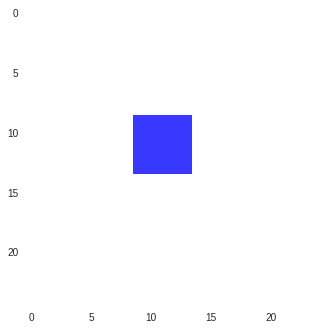

In [369]:
a.plot(-1)

In [370]:
# max_iter=1000, L=5, num_groups=1, num_timesteps_per_group=1 | 78%, 74%, 80%
# max_iter=1000, L=5, num_groups=5, num_timesteps_per_group=20 | 76.5%, 74%

outcome = True
num_failures = 0
num_trials = 0
while num_failures < 20:
  a = Agents(L=5)
  outcome = a.run(max_iter=1000,output=False,num_groups=5,num_timesteps_per_group=20)
  num_trials += 1
  num_failures += bool(not outcome)
  if not outcome:
    print 'failures:',num_failures
  #if outcome:
  #  print 'successes:',num_trials-num_failures
  #print num_trials
print 'success rate:',1-float(20)/num_trials

failures: 1
failures: 2
failures: 3
failures: 4
failures: 5
failures: 6
failures: 7
failures: 8
failures: 9
failures: 10
failures: 11
failures: 12
failures: 13
failures: 14
failures: 15
failures: 16
failures: 17
failures: 18
failures: 19
failures: 20
success rate: 0.775280898876


Agent 20: [(14, 11),🡐,on]-->[(14, 10),🡐,on]
Neighbors: (13, 13) (13, 12) (13, 11)
Edgefollows: (14, 12) (14, 10)


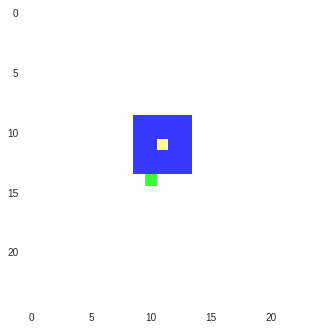

In [336]:
a.plot(-1)

______________________________
t=1
Agent 4: [(10, 14),🡓,on]-->[(9, 14),🡑,on]
Neighbors: (10, 13) (10, 15) (11, 13) (11, 14) (11, 15)
Edgefollows: (9, 14) (9, 15) (9, 13)


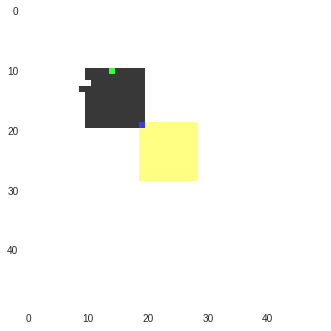

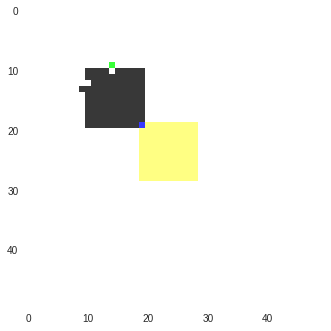

______________________________
t=101
Agent 38: [(14, 18),🡓,on]-->[(14, 19),🡒,on]
Neighbors: (13, 19) (15, 18) (14, 17) (15, 19)
Edgefollows: (13, 18) (14, 19)


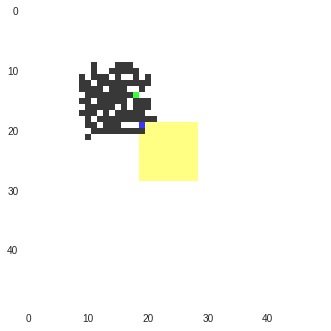

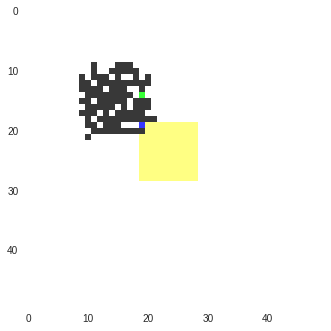

______________________________
t=201
Agent 96: [(20, 16),🡓,on]-->[(20, 15),🡐,on]
Neighbors: (19, 16) (19, 15) (21, 15) (19, 17)
Edgefollows: (20, 15)


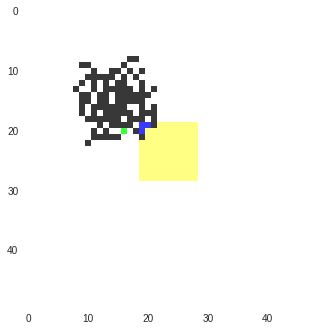

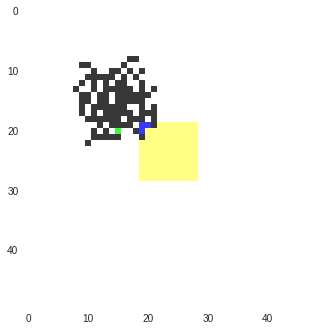

______________________________
t=301
Agent 69: [(19, 22),🡖,on]-->[(20, 22),🡓,on]
Neighbors: (18, 21) (19, 21) (20, 21)
Edgefollows: (18, 22) (20, 22)


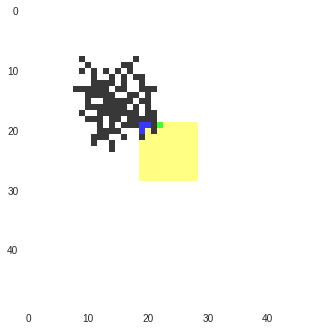

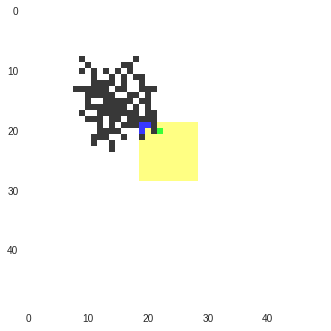

______________________________
t=401
Agent 73: [(17, 14),🡑,on]-->[(17, 15),🡒,on]
Neighbors: (16, 14) (16, 15) (16, 13) (18, 13) (18, 14) (17, 13)
Edgefollows: (17, 15) (18, 15)


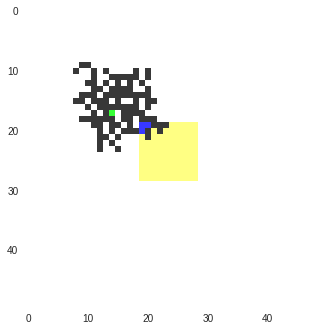

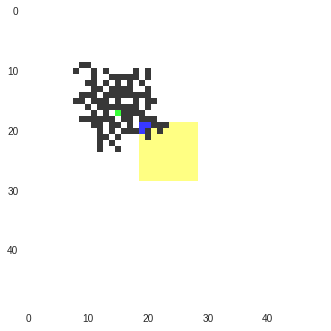

______________________________
t=501
Agent 16: [(10, 18),🡓,on]-->[(11, 18),🡓,on]
Neighbors: (11, 19)
Edgefollows: (10, 19) (11, 18)


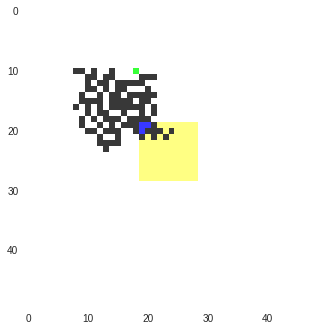

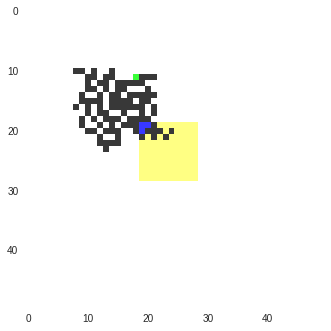

______________________________
t=601
Agent 59: [(22, 23),🡓,on]-->[(21, 23),🡑,on]
Neighbors: (21, 24) (21, 22)
Edgefollows: (21, 23)


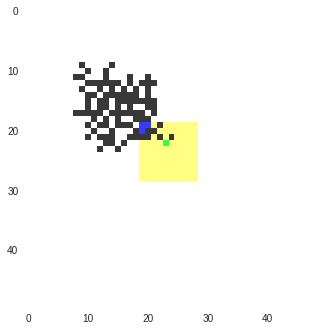

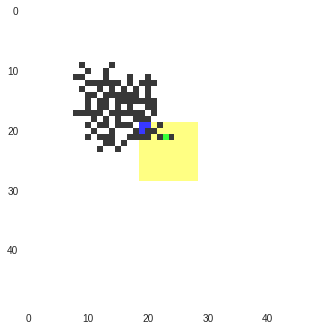

______________________________
t=701
Agent 83: [(13, 9),🡔,on]-->[(12, 9),🡑,on]
Neighbors: (12, 8) (13, 10)
Edgefollows: (12, 9)


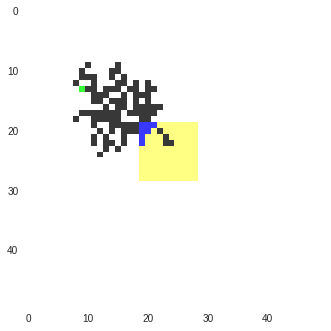

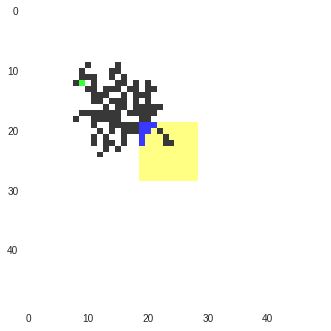

______________________________
t=801
Agent 26: [(14, 20),🡐,on]-->[(14, 19),🡐,on]
Neighbors: (13, 19) (14, 21) (15, 19) (15, 20) (13, 20)
Edgefollows: (13, 21) (15, 21) (14, 19)


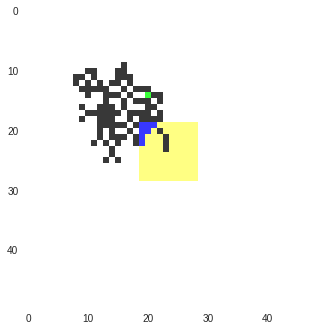

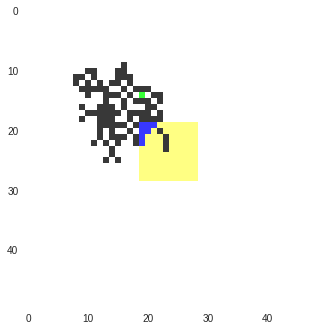

______________________________
t=901
Agent 95: [(17, 11),🡑,on]-->[(16, 11),🡑,on]
Neighbors: (16, 10) (17, 10) (16, 12) (18, 11) (18, 12)
Edgefollows: (16, 11) (17, 12)


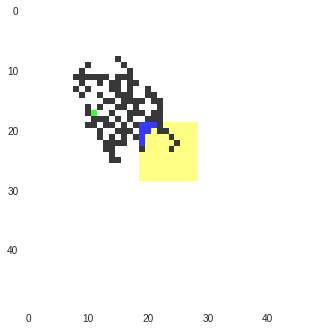

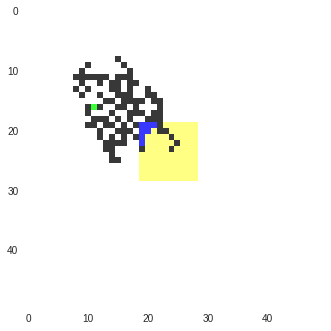

______________________________
t=1001
Agent 13: [(16, 19),🡖,on]-->[(17, 19),🡓,on]
Neighbors: (15, 20) (17, 20) (16, 20)
Edgefollows: (15, 19) (17, 19)


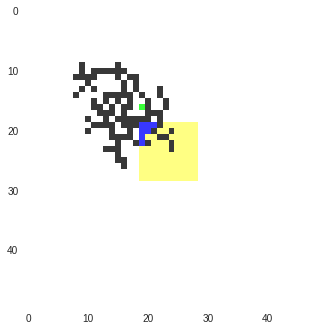

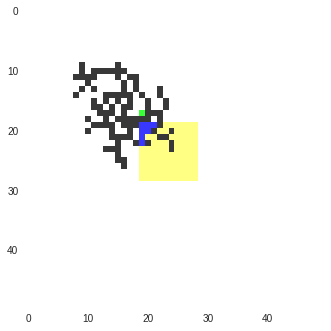

______________________________
t=1101
Agent 16: [(13, 18),🡓,on]-->[(13, 17),🡐,on]
Neighbors: (14, 17) (12, 19) (14, 18) (12, 18) (12, 17)
Edgefollows: (13, 19) (13, 17)


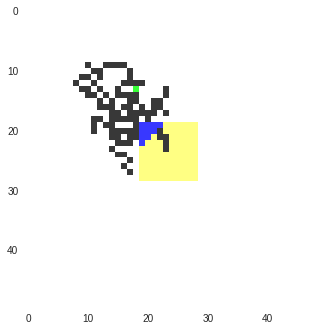

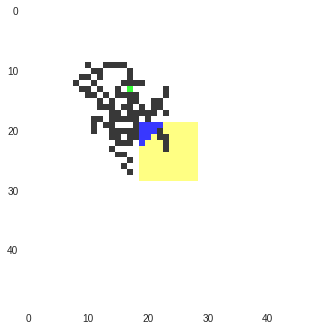

______________________________
t=1201
Agent 83: [(12, 10),🡖,on]-->[(12, 11),🡒,on]
Neighbors: (13, 9) (13, 11) (11, 10) (13, 10)
Edgefollows: (12, 11) (12, 9)


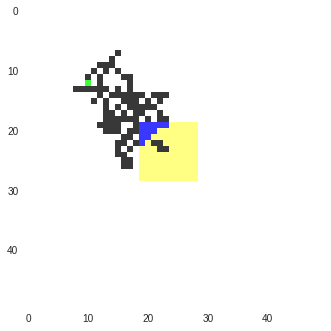

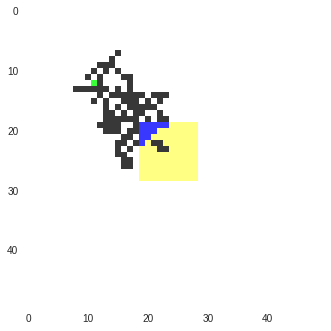

______________________________
t=1301
Agent 46: [(12, 18),🡒,on]-->[(12, 17),🡐,on]
Neighbors: (13, 18) (11, 17)
Edgefollows: (12, 17)


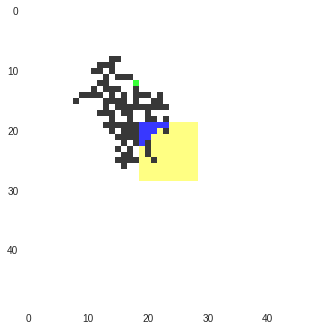

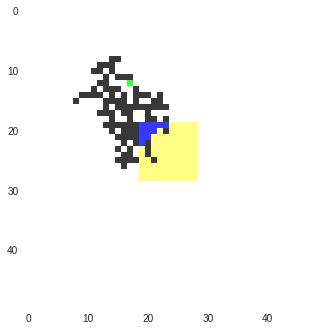

______________________________
t=1401
Agent 84: [(20, 13),🡗,on]-->[(20, 14),🡒,on]
Neighbors: (19, 14)
Edgefollows: (19, 13) (20, 14)


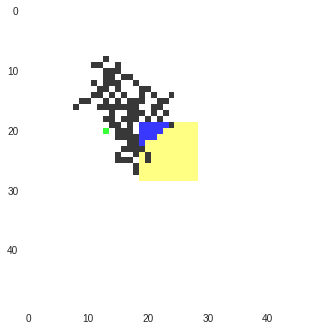

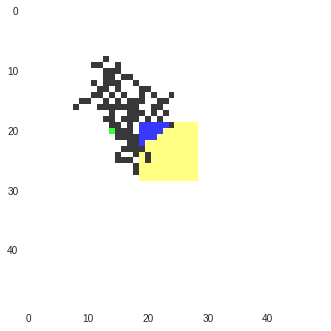

______________________________
t=1501
Agent 24: [(10, 16),🡒,on]-->[(10, 17),🡒,on]
Neighbors: (11, 16) (9, 16) (9, 17) (10, 15)
Edgefollows: (10, 17) (11, 17) (11, 15) (9, 15)


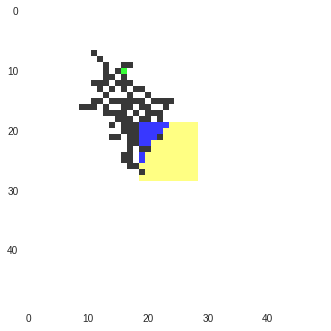

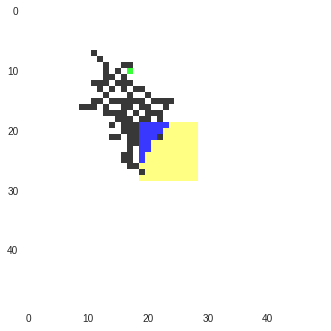

______________________________
t=1601
Agent 25: [(8, 12),🡐,on]-->[(9, 11),🡗,on]
Neighbors: (9, 12) (8, 11)
Edgefollows: (7, 12) (8, 13) (9, 13) (9, 11) (7, 11)


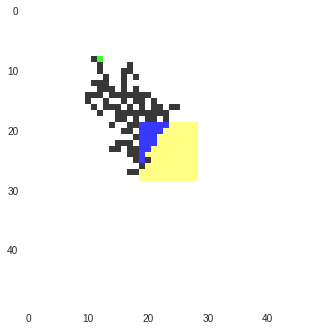

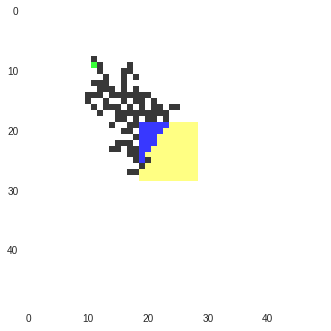

______________________________
t=1701
Agent 92: [(26, 19),🡒,on]-->[(25, 20),🡕,on]
Neighbors: (26, 18) (25, 19) (25, 18)
Edgefollows: (25, 20) (26, 20) (27, 19) (27, 18)


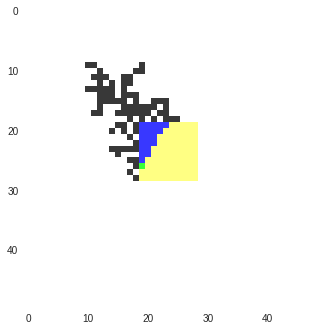

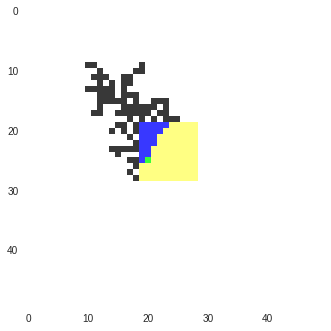

______________________________
t=1801
Agent 14: [(17, 17),🡖,on]-->[(17, 16),🡐,on]
Neighbors: (18, 18) (17, 15) (17, 18) (18, 17) (16, 16) (18, 16)
Edgefollows: (16, 17) (17, 16)


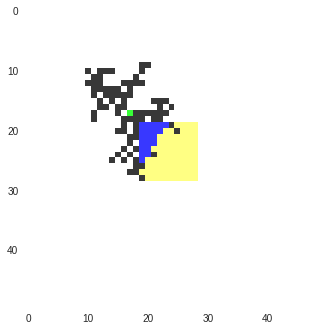

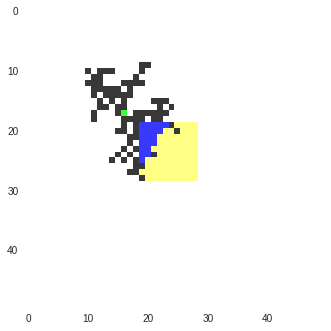

______________________________
t=1901
Agent 55: [(18, 23),🡒,on]-->[(18, 22),🡐,on]
Neighbors: (17, 24) (19, 23) (17, 23) (19, 22)
Edgefollows: (18, 24) (18, 22)


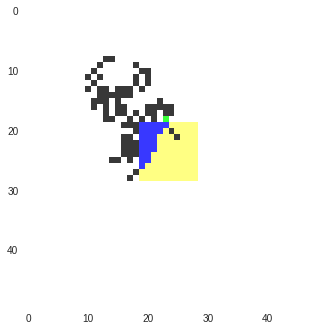

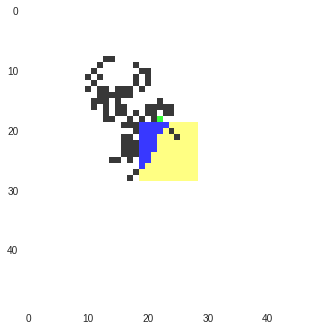

Agent 61: [(18, 22),🡐,on]-->[(18, 21),🡐,on]
Neighbors: (17, 22) (19, 23) (19, 21) (19, 22)
Edgefollows: (18, 23) (18, 21)


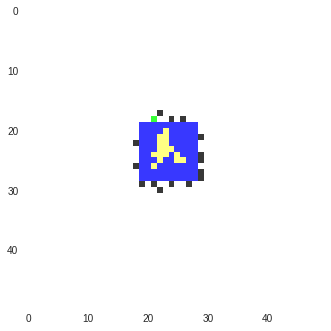

In [313]:
for t in range(1,2000,100):
  print '______________________________'
  print 't='+str(t)
  try:
    a.plot(t)
  except:
    break
a.plot(-1)